### Obtaining Data

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
final = pd.read_csv(r'../../assets/final.csv')
metadata = pd.read_csv(r'../../assets/metadata.csv')

final = final.drop(final.columns[0],
                   axis="columns")  # drop the first column of the index

# final = final.drop(labels=["artist_hotttnesss", "artist_familiarity"], axis="columns")

In [131]:
seed = 100

In [132]:
# final.info()

In [133]:
# final.head(3)

In [134]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_id     13129 non-null  int64 
 1   album_title  13129 non-null  object
 2   artist_name  13129 non-null  object
 3   genre        13129 non-null  object
 4   track_title  13128 non-null  object
dtypes: int64(1), object(4)
memory usage: 513.0+ KB


In [135]:
# metadata.head()

### Model Selection - K Means Algorithm

In [136]:
from sklearn.utils import shuffle
import hdbscan

In [137]:
final = shuffle(final, random_state=seed)

In [138]:
num_enlisted = 2000  # how many songs are enlisted in the user's playlist

# X is the audience's playlist  Recall: iloc is integer position-based
X = final.iloc[[i for i in range(0, num_enlisted)]]

# Y is the music reservoir which are going to be used for the recommendations
Y = final.iloc[[i for i in range(num_enlisted, final.shape[0])]]

In [139]:
X = shuffle(X, random_state=seed)
Y = shuffle(Y, random_state=seed)
X

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
3049,12291,0.008797,0.779822,0.384926,5.665748e-01,0.289584,0.070378,94.945,0.551748,0.449009,0.520527,0.555683,0.000000,0.000000
11180,57808,0.023627,0.339632,0.880221,2.400000e-09,0.321886,0.045908,143.630,0.405866,0.324605,0.282899,0.339108,0.000025,0.038550
5396,21234,0.078061,0.679032,0.839800,2.232774e-01,0.136008,0.046528,125.020,0.909851,0.135619,0.059477,0.141679,0.000000,0.000000
11591,69258,0.390283,0.448094,0.847303,1.910427e-01,0.108648,0.047836,143.663,0.871847,0.460173,0.485004,0.540969,0.000411,0.194578
12249,95910,0.137264,0.709408,0.935570,1.880000e-08,0.083439,0.259614,136.306,0.121195,0.365677,0.255264,0.382015,0.000231,0.097529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7320,31753,0.993398,0.572985,0.473439,8.171597e-01,0.100901,0.038754,84.044,0.355889,0.165592,0.047453,0.172991,0.000000,0.000000
12792,115385,0.095215,0.863822,0.804424,8.498397e-01,0.131887,0.040032,112.455,0.903950,0.366985,0.325918,0.383382,0.000000,0.000000
12865,117517,0.004280,0.558904,0.746316,7.734163e-02,0.082892,0.032707,117.995,0.295729,0.434409,0.457857,0.491494,0.000000,0.000000
8158,35546,0.242228,0.777979,0.229853,8.089146e-01,0.054251,0.034881,95.999,0.838002,0.355983,0.305406,0.371888,0.000000,0.000000


In [140]:
# X.head()

In [141]:
# hdbscan_model = hdbscan.HDBSCAN(
#     algorithm='best', alpha=1.0, prediction_data=True, approx_min_span_tree=True,
#     gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5,
#     min_samples=None, p=None
# )

In [142]:
def fit(df, algo, flag=0):
    df = df.set_index('track_id')
    if flag:
        algo.fit(df)
    else:
        algo.partial_fit(df)
    df['label'] = algo.labels_
    return (df, algo)

In [143]:
def predict(t, Y):
    Y = Y.set_index('track_id')
    y_pred = hdbscan.approximate_predict(t[1], Y)[0]
    mode = pd.Series(y_pred).mode()
    return t[0][t[0]['label'] == mode.loc[0]]

In [144]:
# Y.head()

In [145]:
# t[0] is the new dataframe with the new row indexes and labels of the belonged cluster
# t[1] is the HDBSCAN model after the training

cluster_num = pd.DataFrame({"min_cluster_size", "num_of_clusters", "mean_probability"})
for size in range(5, 25):
    hdbscan_model_vary = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=size, prediction_data=True)
    t = fit(X, hdbscan_model_vary, 1)

    num_of_label = t[1].labels_.max() + 1
    mean_prob = np.mean(t[1].probabilities_)

    print(t[1].labels_.max() + 1)
    # print(np.mean(t[1].probabilities_))

2
2
2
3
4
2
2
2
2
2
2
2
2
3
3
5
7
3
6
5


In [146]:
# reset the fitting model for min_cluster_size=5
hdbscan_model = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=9, prediction_data=True)
t = fit(X, hdbscan_model, 1)

In [147]:
# show the numbers of clusters in the model
print(t[1].labels_.max() + 1)

4


In [148]:
t[0].head(100)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,label
track_id,,,,,,,,,,,,,,
12291,0.008797,0.779822,0.384926,5.665748e-01,0.289584,0.070378,94.945,0.551748,0.449009,0.520527,0.555683,0.000000,0.000000,2
57808,0.023627,0.339632,0.880221,2.400000e-09,0.321886,0.045908,143.630,0.405866,0.324605,0.282899,0.339108,0.000025,0.038550,2
21234,0.078061,0.679032,0.839800,2.232774e-01,0.136008,0.046528,125.020,0.909851,0.135619,0.059477,0.141679,0.000000,0.000000,2
69258,0.390283,0.448094,0.847303,1.910427e-01,0.108648,0.047836,143.663,0.871847,0.460173,0.485004,0.540969,0.000411,0.194578,2
95910,0.137264,0.709408,0.935570,1.880000e-08,0.083439,0.259614,136.306,0.121195,0.365677,0.255264,0.382015,0.000231,0.097529,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15973,0.995252,0.679801,0.234233,9.726512e-01,0.111954,0.052647,84.160,0.793167,0.180170,0.176059,0.188220,0.000000,0.000000,2
12637,0.534367,0.373023,0.916684,8.820587e-01,0.082198,0.139399,188.502,0.779789,0.460580,0.357818,0.481159,0.000360,0.135371,3
4723,0.967319,0.595753,0.570017,2.005618e-01,0.215584,0.050822,145.599,0.400014,0.423558,0.397284,0.442483,0.000003,0.087831,2


[Text(0.5, 1.0, 'HDBSCAN Clustering on energy VS tempo')]

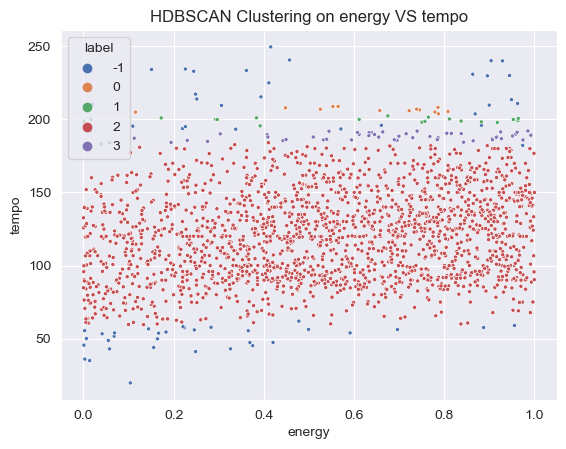

In [149]:
x_label = "energy"
y_label = "tempo"
sns.scatterplot(data=t[0], x=x_label, y=y_label, hue='label', marker=".",palette="deep").set(
    title="HDBSCAN Clustering on " + x_label + " VS " + y_label)

[Text(0.5, 1.0, 'HDBSCAN Clustering on energy VS liveness')]

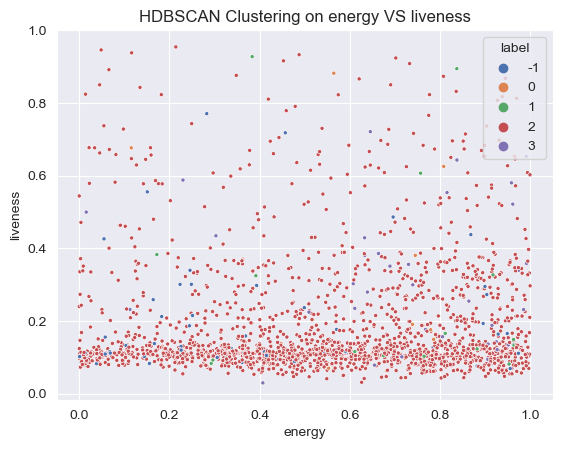

In [150]:
x_label = "energy"
y_label = "liveness"
sns.scatterplot(data=t[0], x=x_label, y=y_label, hue='label', marker=".",palette="deep").set(
    title="HDBSCAN Clustering on " + x_label + " VS " + y_label)

In [151]:
# data = t[0]
# x_name = "danceability"
# y_name = "energy"
#
# for i in range(data.shape[0]):
#     the_label = data["label"][0]
#
#     if the_label.equal(-1):
#         s_n1 = plt.scatter(data[x_name][i], data[y_name][i], s=50, lw=3, color="white")
#     # elif the_label == 0:
#     #     s0 = plt.scatter(data[x_name][i], data[y_name][i], s=50, lw=3, color="red")
#     # elif the_label == 1:
#     #     s1 = plt.scatter(data[x_name][i], data[y_name][i], s=50, lw=3, color="green")
#     # elif the_label == 2:
#     #     s2 = plt.scatter(data[x_name][i], data[y_name][i], s=50, lw=3, color="blue")
#     # elif the_label == 3:
#     #     s3 = plt.scatter(data[x_name][i], data[y_name][i], s=50, lw=3, color="yellow")
#
# plt.legend((s_n1, s0, s1, s2, s3), ('noise', "0", "1", "2", "3",), loc='best')

In [152]:
recommendations = predict(t, Y)

In [153]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 12291 to 4216
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   acousticness        1854 non-null   float64
 1   danceability        1854 non-null   float64
 2   energy              1854 non-null   float64
 3   instrumentalness    1854 non-null   float64
 4   liveness            1854 non-null   float64
 5   speechiness         1854 non-null   float64
 6   tempo               1854 non-null   float64
 7   valence             1854 non-null   float64
 8   artist_discovery    1854 non-null   float64
 9   artist_familiarity  1854 non-null   float64
 10  artist_hotttnesss   1854 non-null   float64
 11  song_currency       1854 non-null   float64
 12  song_hotttnesss     1854 non-null   float64
 13  label               1854 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 217.3 KB


In [154]:
recommendations.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,label
track_id,,,,,,,,,,,,,,
12291,0.008797,0.779822,0.384926,5.665748e-01,0.289584,0.070378,94.945,0.551748,0.449009,0.520527,0.555683,0.000000,0.000000,2
57808,0.023627,0.339632,0.880221,2.400000e-09,0.321886,0.045908,143.630,0.405866,0.324605,0.282899,0.339108,0.000025,0.038550,2
21234,0.078061,0.679032,0.839800,2.232774e-01,0.136008,0.046528,125.020,0.909851,0.135619,0.059477,0.141679,0.000000,0.000000,2
69258,0.390283,0.448094,0.847303,1.910427e-01,0.108648,0.047836,143.663,0.871847,0.460173,0.485004,0.540969,0.000411,0.194578,2
95910,0.137264,0.709408,0.935570,1.880000e-08,0.083439,0.259614,136.306,0.121195,0.365677,0.255264,0.382015,0.000231,0.097529,2


In [155]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_id     13129 non-null  int64 
 1   album_title  13129 non-null  object
 2   artist_name  13129 non-null  object
 3   genre        13129 non-null  object
 4   track_title  13128 non-null  object
dtypes: int64(1), object(4)
memory usage: 513.0+ KB


In [156]:
metadata = metadata.set_index('track_id')

In [157]:
Y.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
3979,15866,0.126620,0.444495,0.687881,0.460171,0.092639,0.374912,189.879,0.353370,0.442439,0.357309,0.462207,0.0,0.003068
10634,49464,0.007757,0.647147,0.836007,0.880194,0.192954,0.029688,99.950,0.387107,0.323548,0.387238,0.338004,0.0,0.000000
354,885,0.069900,0.385746,0.707775,0.937884,0.203171,0.105063,123.453,0.039475,0.405436,0.369210,0.423551,0.0,0.000000
8874,39685,0.000707,0.849537,0.540725,0.934993,0.098529,0.088324,121.976,0.684539,0.444844,0.328891,0.464720,0.0,0.000000
6630,28348,0.276979,0.452824,0.842640,0.135532,0.097390,0.416882,177.627,0.969982,0.262087,0.148808,0.273797,0.0,0.000000


In [158]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11129 entries, 3979 to 5644
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            11129 non-null  int64  
 1   acousticness        11129 non-null  float64
 2   danceability        11129 non-null  float64
 3   energy              11129 non-null  float64
 4   instrumentalness    11129 non-null  float64
 5   liveness            11129 non-null  float64
 6   speechiness         11129 non-null  float64
 7   tempo               11129 non-null  float64
 8   valence             11129 non-null  float64
 9   artist_discovery    11129 non-null  float64
 10  artist_familiarity  11129 non-null  float64
 11  artist_hotttnesss   11129 non-null  float64
 12  song_currency       11129 non-null  float64
 13  song_hotttnesss     11129 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.3 MB


In [159]:
#Y = Y.reset_index(level=0)

In [160]:
#recommendations = recommendations.reset_index(level=0)

In [161]:
def recommend(recommendations, meta, Y):
    recommendations = recommendations.reset_index(level=0)
    Y = Y.reset_index(level=0)
    dat = []
    for i in Y['track_id']:
        dat.append(i)
    genre_mode = meta.loc[dat]['genre'].mode()
    artist_mode = meta.loc[dat]['artist_name'].mode()
    return meta[meta['genre'] == genre_mode.iloc[0]], meta[meta['artist_name'] == artist_mode.iloc[0]], meta.loc[
        recommendations['track_id']]

In [162]:
output = recommend(recommendations, metadata, Y)

In [163]:
genre_recommend, artist_name_recommend, mixed_recommend = output[0], output[1], output[2]

In [164]:
genre_recommend.shape

(3892, 4)

In [165]:
artist_name_recommend.shape

(94, 4)

In [166]:
mixed_recommend.shape

(1854, 4)

In [167]:
# Genre wise recommendations
genre_recommend.head()

,album_title,artist_name,genre,track_title
track_id,,,,
153,Arc and Sender,Arc and Sender,Rock,Hundred-Year Flood
154,Arc and Sender,Arc and Sender,Rock,Squares And Circles
155,unreleased demo,Arc and Sender,Rock,Maps of the Stars Homes
169,Boss of Goth,Argumentix,Rock,Boss of Goth
170,Nightmarcher,Argumentix,Rock,Industry Standard Massacre


In [168]:
# Artist wise recommendations
artist_name_recommend.head()

,album_title,artist_name,genre,track_title
track_id,,,,
10381,Big Blood & The Bleedin' Hearts,Big Blood,Folk,Baron in the Trees
10382,Big Blood & The Bleedin' Hearts,Big Blood,Folk,New Dish Rag
10383,Big Blood & The Bleedin' Hearts,Big Blood,Folk,Graceless Lady
10384,Big Blood & The Bleedin' Hearts,Big Blood,Folk,Blood Mumble
10385,Big Blood & The Bleedin' Hearts,Big Blood,Folk,Curee


In [169]:
# Mixed Recommendations
mixed_recommend.head()

,album_title,artist_name,genre,track_title
track_id,,,,
12291,Wakka Chikka Wakka Chikka: Porn Music for the ...,Marcel,AvantGarde|International|Blues|,Strange Wedding 60908
57808,Live at WFMU on The Cherry Blossom Clinic with...,Happy Refugees,Rock,Inertia
21234,ccMixter,mykleanthony,Electronic,Youre My Everything (ft. Beckford)
69258,"Live at WFMU on the Cherry Blossom Clinic, Aug...",Sonny & The Sunsets,Rock,Void
95910,Genital Warfare,Suicidal Rap Orgy,HipHop,Murder Rap


In [170]:
recommendations

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,label
track_id,,,,,,,,,,,,,,
12291,0.008797,0.779822,0.384926,5.665748e-01,0.289584,0.070378,94.945,0.551748,0.449009,0.520527,0.555683,0.000000,0.000000,2
57808,0.023627,0.339632,0.880221,2.400000e-09,0.321886,0.045908,143.630,0.405866,0.324605,0.282899,0.339108,0.000025,0.038550,2
21234,0.078061,0.679032,0.839800,2.232774e-01,0.136008,0.046528,125.020,0.909851,0.135619,0.059477,0.141679,0.000000,0.000000,2
69258,0.390283,0.448094,0.847303,1.910427e-01,0.108648,0.047836,143.663,0.871847,0.460173,0.485004,0.540969,0.000411,0.194578,2
95910,0.137264,0.709408,0.935570,1.880000e-08,0.083439,0.259614,136.306,0.121195,0.365677,0.255264,0.382015,0.000231,0.097529,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31753,0.993398,0.572985,0.473439,8.171597e-01,0.100901,0.038754,84.044,0.355889,0.165592,0.047453,0.172991,0.000000,0.000000,2
115385,0.095215,0.863822,0.804424,8.498397e-01,0.131887,0.040032,112.455,0.903950,0.366985,0.325918,0.383382,0.000000,0.000000,2
117517,0.004280,0.558904,0.746316,7.734163e-02,0.082892,0.032707,117.995,0.295729,0.434409,0.457857,0.491494,0.000000,0.000000,2


In [171]:
artist_name_recommend['artist_name'].value_counts()

Big Blood    94
Name: artist_name, dtype: int64

In [172]:
genre_recommend['genre'].value_counts()

Rock    3892
Name: genre, dtype: int64

In [173]:
genre_recommend['artist_name'].value_counts()

Glove Compartment               65
Blah Blah Blah                  62
Mors Ontologica                 50
Les Baudouins Morts             38
Kraus                           35
                                ..
Alone in 1982                    1
Ostrich Tuning                   1
The Dalai Lama Rama Fa Fa Fa     1
The Rusty Bells                  1
Lost Boy                         1
Name: artist_name, Length: 725, dtype: int64

#### Testing

In [174]:
testing = Y.iloc[6:12]['track_id']

In [175]:
testing

818        1834
5500      21963
9011      40422
6964      30000
5772      23318
12585    109073
Name: track_id, dtype: int64

In [176]:
ids = testing.loc[testing.index]

In [177]:
songs = metadata.loc[testing.loc[list(testing.index)]]

In [178]:
songs

,album_title,artist_name,genre,track_title
track_id,,,,
1834,The Glove Compartment,Glove Compartment,Rock,Mr. Feleppa...Goes to...
21963,You Sick Little Monkey,Psilodump,Electronic,Follow the Leaders
40422,gleanings and gatherings,Mt. Gigantic,AvantGarde|International|,Get Well Cougher
30000,This is the New Yeah!,Bleeptor V. Telescope,Electronic,We will dance to Tokyo waltz
23318,Accident Consultancy Live / Undead,THF Drenching,AvantGarde|International|,Santa Head Orchestration Revolt (Undead)
109073,Workers in Kontrol,Kraus,Rock,Killer


In [179]:
re = predict(t, Y.iloc[6:12])

In [180]:
output = recommend(re, metadata, Y.iloc[6:12])

In [181]:
ge_re, ge_ar, ge_mix = output[0], output[1], output[2]

In [182]:
ge_re.head()

,album_title,artist_name,genre,track_title
track_id,,,,
236,Bersa Discos #8,Banana Clipz,AvantGarde|International|,"Push Am (Left, Right)"
461,blissblood.com,Cantonement Jazz Band,AvantGarde|International|,Bessemer
462,blissblood.com,Cantonement Jazz Band,AvantGarde|International|,Has Been Blues
463,blissblood.com,Cantonement Jazz Band,AvantGarde|International|,I'll Be Blue
464,blissblood.com,Cantonement Jazz Band,AvantGarde|International|,The Way I Feel Today


In [183]:
ge_ar.head(10)

,album_title,artist_name,genre,track_title
track_id,,,,
30000,This is the New Yeah!,Bleeptor V. Telescope,Electronic,We will dance to Tokyo waltz


In [184]:
ge_mix.head(10)

,album_title,artist_name,genre,track_title
track_id,,,,
12291,Wakka Chikka Wakka Chikka: Porn Music for the ...,Marcel,AvantGarde|International|Blues|,Strange Wedding 60908
57808,Live at WFMU on The Cherry Blossom Clinic with...,Happy Refugees,Rock,Inertia
21234,ccMixter,mykleanthony,Electronic,Youre My Everything (ft. Beckford)
69258,"Live at WFMU on the Cherry Blossom Clinic, Aug...",Sonny & The Sunsets,Rock,Void
95910,Genital Warfare,Suicidal Rap Orgy,HipHop,Murder Rap
23177,Exotica,Juanitos,AvantGarde|International|Blues|,Exotica
13128,Simulators can,Gorowski,Electronic,simulators can
50579,Something EP,Broke For Free,AvantGarde|International|,Something Old
27274,DC03,HCI,Jazz,Elpossible I


In [185]:
ge_re.shape

(1902, 4)

In [186]:
ge_ar.shape

(1, 4)

In [187]:
ge_mix.shape

(1854, 4)